# Final Project DL model Notebook - Retrain Model From User Data

improve and adapt model using data collected in the real world

In [1]:
import sys

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from utils import *

# Model and data dirs
current_dir = Path.cwd()
MODEL_NAME = 'CNN_two_convs_30122017_1700.h5'
HOME_DIR = current_dir.parent
MODEL_DIR = HOME_DIR.joinpath('savedModels/30122017/')
MODEL = MODEL_DIR.joinpath(MODEL_NAME)

DATA_DIR = HOME_DIR.joinpath('data/')
VAL_DATA_DIR = DATA_DIR.joinpath('valid')
# RETRAIN_DATA_DIR = DATA_DIR.joinpath('retrainBatch01-28-02-2018/labelled/')
RETRAIN_DATA_DIR = DATA_DIR.joinpath('train/')
RETRAIN_DATA_DIR = DATA_DIR.joinpath('train/')

# training variables
batch_size = 64
epochs = 5
learning_rate = 1e-5

Using Theano backend.
Using cuDNN version 5103 on context None
Preallocating 10867/11439 Mb (0.950000) on cuda
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)


In [2]:
model = load_model(MODEL)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 3, 224, 224)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 222, 222)      896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 222, 222)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 74, 74)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 72, 72)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 72, 72)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 24, 24)        0         
__________

## Validate current performance of the loaded model

we loaded the existing model, and now run a quick test to see how the model is currently performing on the validation data set as a benchmark

In [5]:
datagen = ImageDataGenerator()
validation_generator = datagen.flow_from_directory(
        VAL_DATA_DIR,
        target_size=(224, 224),
        batch_size=batch_size)

Found 5000 images belonging to 10 classes.


In [6]:
perf = [model.evaluate_generator(validation_generator, 5000 // batch_size) for i in range(10)]

In [7]:
print(model.metrics_names)
np.round(perf, 6)

['loss', 'acc']


array([[ 0.012,  0.997],
       [ 0.012,  0.997],
       [ 0.012,  0.997],
       [ 0.012,  0.997],
       [ 0.012,  0.997],
       [ 0.012,  0.997],
       [ 0.012,  0.997],
       [ 0.012,  0.997],
       [ 0.012,  0.997],
       [ 0.012,  0.997]])

## Now we are going to retrain the classifier on the new data that we collected from the users

In [8]:
# setting a low learning rate, as the model is already quite good, and we merely want it to adapy better to the 
# generated data
model.optimizer.lr.set_value(learning_rate)
retrain_batches = get_in_batches(RETRAIN_DATA_DIR, batch_size=batch_size, augment=True)
val_batches = get_in_batches(VAL_DATA_DIR, batch_size=batch_size, augment=True)

Found 22424 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


In [9]:
history = model.fit_generator(retrain_batches,
                    steps_per_epoch=retrain_batches.n//retrain_batches.batch_size,
                    validation_data=val_batches,
                    validation_steps=1,
                    epochs=epochs,
                    callbacks=[reduce_lr, stop_early])

Epoch 1/5
350/350 [==============================] - 294s - loss: 0.9957 - acc: 0.7035 - val_loss: 0.3719 - val_acc: 0.9219
Epoch 2/5
350/350 [==============================] - 293s - loss: 0.5076 - acc: 0.8347 - val_loss: 0.5173 - val_acc: 0.8281
Epoch 3/5
350/350 [==============================] - 295s - loss: 0.3623 - acc: 0.8872 - val_loss: 0.3403 - val_acc: 0.8594
Epoch 4/5
350/350 [==============================] - 292s - loss: 0.2874 - acc: 0.9151 - val_loss: 0.1326 - val_acc: 0.9844
Epoch 5/5
350/350 [==============================] - 293s - loss: 0.2367 - acc: 0.9293 - val_loss: 0.1455 - val_acc: 1.0000


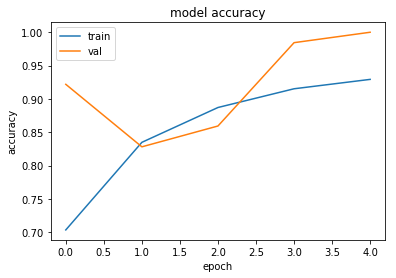

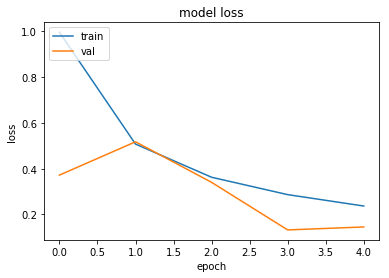

In [10]:
plot_acc_and_loss(history)